In [2]:
import pickle
from PIL import Image
import numpy as np
from tqdm import tqdm

target_size = 256

In [3]:
## 피클파일 없을 때 실행

# 메타데이터 및 텍스트 데이터 로드

train_path = './train_data/%s'
metadata = pickle.load(open('./data/sentence_gamjung2.pkl', 'rb'))

# clean_text에 시작, 끝 추가
# clean_text 기준 256글자 넘지 않도록 필터링
# 각 감정 클래스가 최대한 균등하도록 샘플 추출
# 학습 5000, 검증 1000, 테스트 1000

metadata['clean_text'] = metadata['clean_text'].apply(lambda x: '\t%s\n' %x.strip())
metadata = metadata[metadata['clean_text'].str.len() <= 256]

sentiment_list = ['emotion_0', 'emotion_1', 'emotion_3', 'emotion_4']
sentiment_indices = [metadata[metadata[senti] == 1].index for senti in sentiment_list]
data_indices = []

i = 0
condition = True
while condition:
    for senti in sentiment_indices:
        if len(set(data_indices)) < 7000:
            data_indices.append(senti[i])
        else:
            condition = False
            break
    i += 1
    
metadata = metadata.iloc[sorted(list(set(data_indices)))]

def get_image_from_path(path):
    image = Image.open(train_path %path)
    size = image.size

    if size[0] <= size[1]:
        scaled_size = (target_size, int(size[1]/size[0]*target_size))
        crop_area = (0, int((scaled_size[1]-target_size)/2), target_size, int((scaled_size[1]+target_size)/2))
    else:
        scaled_size = (int(size[0]/size[1]*target_size), target_size)
        crop_area = (int((scaled_size[0]-target_size)/2), 0, int((scaled_size[0]+target_size)/2), target_size)

    image = image.resize(scaled_size)
    image = image.crop(crop_area)
    return image

def get_array_from_path(path):
    return np.asarray(get_image_from_path(path))

# 이미지 불러와서 데이터셋 생성
image_data = np.array([image for image in metadata['image_path'].map(get_array_from_path)])
sentiment_data = np.array(metadata[sentiment_list])
sentence_data = np.array(metadata['clean_text'])

# 데이터 피클로 저장
pickle.dump([image_data, sentiment_data, sentence_data], open('data.pkl', 'wb'))

FileNotFoundError: [Errno 2] No such file or directory: './data/sentence_gamjung2.pkl'

In [4]:
# 피클로 저장된 데이터 로드
image_data, sentiment_data, sentence_data = pickle.load(open('data_100.pkl', 'rb'))

In [5]:
print(image_data.shape)
print(sentiment_data.shape)
print(sentence_data.shape)

(7000, 256, 256, 3)
(7000, 4)
(7000,)


In [6]:
length_dict = {}
for l in map(len, sentence_data):
    if l in length_dict:
        length_dict[l] += 1
    else:
        length_dict[l] = 1

count = 0
for l, c in length_dict.items():
    if l <= 100:
        count += c
count

7000

In [3]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

tf.reset_default_graph()

Instructions for updating:
non-resource variables are not supported in the long term


In [4]:
# 이미지 (CNN)

X = tf.placeholder(tf.float32, shape=[None, target_size, target_size, 3])

n_conv_1 = 64
k_conv_1 = 7
W_conv_1 = tf.Variable(tf.truncated_normal(shape=[k_conv_1,k_conv_1,3,n_conv_1], stddev=5e-2))
b_conv_1 = tf.Variable(tf.constant(0.1, shape=[n_conv_1]))
h_conv_1 = tf.nn.relu(tf.nn.conv2d(X, W_conv_1, strides=[1,1,1,1], padding='SAME') + b_conv_1)
h_pool_1 = tf.nn.max_pool(h_conv_1, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')

n_conv_2 = 64
k_conv_2 = 5
W_conv_2 = tf.Variable(tf.truncated_normal(shape=[k_conv_2,k_conv_2,n_conv_1,n_conv_2], stddev=5e-2))
b_conv_2 = tf.Variable(tf.constant(0.1, shape=[n_conv_2]))
h_conv_2 = tf.nn.relu(tf.nn.conv2d(h_pool_1, W_conv_2, strides=[1,1,1,1], padding='SAME') + b_conv_2)
h_pool_2 = tf.nn.max_pool(h_conv_2, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')

n_conv_3 = 128
k_conv_3 = 5
W_conv_3 = tf.Variable(tf.truncated_normal(shape=[k_conv_3,k_conv_3,n_conv_2,n_conv_3], stddev=5e-2))
b_conv_3 = tf.Variable(tf.constant(0.1, shape=[n_conv_3]))
h_conv_3 = tf.nn.relu(tf.nn.conv2d(h_pool_2, W_conv_3, strides=[1,1,1,1], padding='SAME') + b_conv_3)
h_pool_3 = tf.nn.max_pool(h_conv_3, ksize=[1,3,3,1], strides=[1,2,2,1], padding='SAME')

n_conv_4 = 128
k_conv_4 = 3
W_conv_4 = tf.Variable(tf.truncated_normal(shape=[k_conv_4,k_conv_4,n_conv_3,n_conv_4], stddev=5e-2))
b_conv_4 = tf.Variable(tf.constant(0.1, shape=[n_conv_4]))
h_conv_4 = tf.nn.relu(tf.nn.conv2d(h_pool_3, W_conv_4, strides=[1,1,1,1], padding='SAME') + b_conv_4)

n_conv_5 = 128
k_conv_5 = 3
W_conv_5 = tf.Variable(tf.truncated_normal(shape=[k_conv_5,k_conv_5,n_conv_4,n_conv_5], stddev=5e-2))
b_conv_5 = tf.Variable(tf.constant(0.1, shape=[n_conv_5]))
h_conv_5 = tf.nn.relu(tf.nn.conv2d(h_conv_4, W_conv_5, strides=[1,1,1,1], padding='SAME') + b_conv_5)
h_conv_5_flat = tf.reshape(h_conv_5, [-1, h_conv_5.shape[1]*h_conv_5.shape[2]*h_conv_5.shape[3]])

n_fc_1 = 256
k_conv_1 = 5
W_fc_1 = tf.Variable(tf.truncated_normal(shape=[h_conv_5_flat.shape[1], n_fc_1], stddev=5e-2))
b_fc_1 = tf.Variable(tf.constant(0.1, shape=[n_fc_1]))
h_fc_1 = tf.nn.relu(tf.matmul(h_conv_5_flat, W_fc_1) + b_fc_1)

h_fc_1_drop = tf.nn.dropout(h_fc_1, 0.8)

NameError: name 'target_size' is not defined

In [2]:
h_fc_1_drop

NameError: name 'h_fc_1_drop' is not defined

In [78]:
# 감정

n_senti = 4

S = tf.placeholder(tf.float32, shape=[None, n_senti])

h_pre_s = tf.tile(h_fc_1_drop, [1, n_senti]) * tf.repeat(S, n_fc_1, axis=1)

n_final = 512
W_final = tf.Variable(tf.truncated_normal(shape=[n_senti*n_fc_1, n_final]))
b_final = tf.Variable(tf.constant(0.1, shape=[n_final]))
h_final = tf.matmul(h_pre_s, W_final) + b_final

In [79]:
# RNN 준비과정

output_chars = set()
for s in sentence_data:
    for c in s:
        if c not in output_chars:
            output_chars.add(c)
            
output_chars = sorted(list(output_chars))
output_dict = {c: i for i, c in enumerate(output_chars)}
dict_len = len(output_dict)
max_seq_length = 100

In [80]:
# 문장 생성 (RNN)

learning_rate = 0.001
n_hidden = 128
n_class = n_input = dict_len

enc_input = tf.reshape(h_final, [-1, n_final, 1])
# [batch_size, time_steps, input_size]
dec_input = tf.placeholder(tf.float32, [None, max_seq_length, n_input])
# [batch_size, time_steps]
dec_output = tf.placeholder(tf.int64, [None, max_seq_length])

with tf.variable_scope('encode'):
    enc_cell = tf.nn.rnn_cell.GRUCell(n_hidden)
    enc_cell = tf.nn.rnn_cell.DropoutWrapper(enc_cell, output_keep_prob=0.8)
    outputs, enc_states = tf.nn.dynamic_rnn(enc_cell, enc_input, dtype=tf.float32)

with tf.variable_scope('decode'):
    dec_cell = tf.nn.rnn_cell.GRUCell(n_hidden)
    dec_cell = tf.nn.rnn_cell.DropoutWrapper(dec_cell, output_keep_prob=0.8)
    outputs, dec_states = tf.nn.dynamic_rnn(dec_cell, dec_input, 
                                            initial_state=enc_states,
                                            dtype=tf.float32)

model = tf.layers.dense(outputs, n_class, activation=None)
cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model, labels=dec_output))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

Instructions for updating:
This class is equivalent as tf.keras.layers.GRUCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [81]:
with tf.device('/gpu:0'):
    sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True, 
                                            log_device_placement=True))
    sess.run(tf.global_variables_initializer())

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:68:00.0, compute capability: 7.5



In [82]:
total_epoch = 10
total_size = 5000
valid_size = 1000
batch_size = 100
n_batch = total_size // batch_size
n_valid = valid_size // batch_size

dec_input_data = np.zeros(shape=(len(sentence_data), max_seq_length, len(output_chars)), dtype='float32')
dec_output_data = np.zeros(shape=(len(sentence_data), max_seq_length), dtype='int32')

for i, s in enumerate(sentence_data):
    for j, c in enumerate(s):
        dec_input_data[i, j, output_dict[c]] = 1.
        if j > 0:
            dec_output_data[i, j-1] = output_dict[c]

valid_image = image_data[total_size:total_size+valid_size]
valid_sentiments = sentiment_data[total_size:total_size+valid_size]
valid_input_data = np.zeros(shape=(valid_size, max_seq_length, len(output_chars)), dtype='float32')
valid_output_data = np.zeros(shape=(valid_size, max_seq_length), dtype='int32')

for i, s in enumerate(sentence_data[total_size:total_size+valid_size]):
    for j, c in enumerate(s):
        if j == 0:
            valid_input_data[i, j, output_dict[c]] = 1.
        else:
            valid_output_data[i, j-1] = output_dict[c]

In [83]:
print('image', image_data.shape)
print('sentiment', sentiment_data.shape)
print('dec_input', dec_input_data.shape)
print('dec_output', dec_output_data.shape)
print()
print('valid_image', valid_image.shape)
print('valid_sentiment', valid_sentiments.shape)
print('valid_dec_input', valid_input_data.shape)
print('valid_dec_output', valid_output_data.shape)

image (7000, 256, 256, 3)
sentiment (7000, 4)
dec_input (7000, 100, 1588)
dec_output (7000, 100)

valid_image (1000, 256, 256, 3)
valid_sentiment (1000, 4)
valid_dec_input (1000, 100, 1588)
valid_dec_output (1000, 100)


In [93]:
for epoch in range(total_epoch):
    total_loss = 0
    for batch in tqdm(range(n_batch)):
        # print('sect: %03d batch: %03d' %(section, batch))
        batch_images = image_data[batch_size*batch:batch_size*(batch+1)]
        batch_sentiments = sentiment_data[batch_size*batch:batch_size*(batch+1)]
        batch_dec_inputs = dec_input_data[batch_size*batch:batch_size*(batch+1)]
        batch_dec_outputs = dec_output_data[batch_size*batch:batch_size*(batch+1)]

        _, loss = sess.run([optimizer, cost], feed_dict={
            X: batch_images,
            S: batch_sentiments,
            dec_input: batch_dec_inputs,
            dec_output: batch_dec_outputs
        })

        total_loss += loss
        
    total_valid_loss = 0
    for batch in range(n_valid):
        valid_loss = sess.run(cost, feed_dict={
            X: valid_image[batch_size*batch:batch_size*(batch+1)],
            S: valid_sentiments[batch_size*batch:batch_size*(batch+1)],
            dec_input: valid_input_data[batch_size*batch:batch_size*(batch+1)],
            dec_output: valid_output_data[batch_size*batch:batch_size*(batch+1)]
        })
        total_valid_loss += valid_loss
        

    print('Epoch: %04d Cost: %.6f Valid Cost: %.6f' %(epoch + 1, total_loss / n_batch, valid_loss))

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0001 Cost: 1.404779 Valid Cost: 5.753175


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0002 Cost: 1.395230 Valid Cost: 5.745071


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0003 Cost: 1.386459 Valid Cost: 5.889375


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0004 Cost: 1.378552 Valid Cost: 5.534346


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0005 Cost: 1.370771 Valid Cost: 5.580034


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0006 Cost: 1.362968 Valid Cost: 5.420713


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0007 Cost: 1.355641 Valid Cost: 6.003225


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0008 Cost: 1.348040 Valid Cost: 4.944407


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 0009 Cost: 1.341832 Valid Cost: 5.137182


100%|██████████| 50/50 [00:30<00:00,  1.64it/s]


Epoch: 0010 Cost: 1.335065 Valid Cost: 3.788464


In [94]:
def translate(image, senti):
    prediction = tf.argmax(model, 2)
    dec_inp = [0] + [2]*(max_seq_length-1)
    dec_inp = [np.eye(dict_len)[dec_inp]]
    dec_out = np.zeros(shape=(1, max_seq_length, ))
    dec_out = [[2]*(max_seq_length-1) + [1]]
    # dec_out = np.eye(dict_len)[dec_out]
    result = sess.run(prediction, 
                      feed_dict={X: image,
                                 S: senti,
                                 dec_input: dec_inp,
                                 dec_output: dec_out})
    decoded = [output_chars[i] for i in result[0]]
    end = decoded.index('\n') if '\n' in decoded else len(decoded)
    translated = ''.join(decoded[:end])
    return translated

In [95]:
idx_start = 3000

for idx in range(idx_start, idx_start + 10):
    print(idx, ':', sentence_data[idx:idx+1])
    print(idx, ':', translate(image_data[idx:idx+1], sentiment_data[idx:idx+1]))

3000 : ['\t주일 개월일 이사와서 좋은점 하늘을 맘껏 감상할 수있어요 넘 예쁜 가을하늘\n']
3000 : 오제시수수수사수수수수수수기어주일수수사어사가수수기수가수동사수수어가이가사수가나가수수안수수이사이사수기수수나수어사수사가수수수수수사시사가시가기시수가먹가수수수가사이가수가수가사가수가수수수수수시
3001 : ['\t엄마 시리얼이 이렇게 맛있는거 였나유\n']
3001 : 오늘수수수사수수수가수수사시수수수가사어수일사사수수가수수시수가가수수사가수수사일수가수동수일수수수가어수시수수이수가가기시가이수시수가사가수시수수시시사수사사시수수수가사수시가시시기수수수수시가나가
3002 : ['\t엄마랑 처음 찍어본 셀콰 엄마를 가리려고 꾸몄더니 사진이 유치찬란 하구나 사진잘찍은것에 의미를 두자 내일은 울이쥬니 예방접종 개나 심히 걱정되는군아 잘하자 이쥬나\n']
3002 : 오사어동일안수수수수수수사사수이사수주수수수수가수수시수가수사수사시가수마수수기수가사가시사일기기수사분가가수가수수수시가사가분시수시사수가나분수수이어수분사이수수기사사수시수사가사시가수일수사수수이
3003 : ['\t넘 좋다는 말만 번한날 여긴 꼭 다시가야지\n']
3003 : 우사사안수수나수이수시분수사사가수수사수이수가사이수수사수기일이수가수사수수가수수수가기어수수가사가수분수수수수시수사가가수가시동수수일동마가수가수사수사수일수수수가가마사수수수나수수마수시수마이가가
3004 : ['\t늦은 밤 숑이랑 산책하다 네일샷 예쁘지만 맘은 불쾌했던\n']
3004 : 오사늘어수수수수수수수수나수이수수사수시수수가수수수수가이수수가수사어가수기수사가시사기수이가가사수거기일수수수시사시사수시사마사사이수수수수기수이수가수수사사가수안동주일사수수시수수마가번사수시이일
3005 : ['\t사람없어서 좋았던\n']
3005 : 오사일어수사수수사수수스수수수수가수사가수시가기시안주기사수가수가시사시사분시수수시가시가사수수수시수사일수가일가수수수수일수수가수수시가수수이수사사수사수수수수수가사수가수수수사시수수시가이수수수수
3006 : ['\t이번 생일은 소중한 사람과 제주에서 보내며 많은 사람들에게

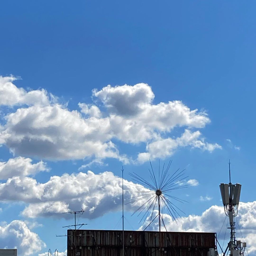

In [74]:
Image.fromarray(image_data[3])

In [51]:
sess.close()